In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import os
from PIL import ImageColor, ImageFont, Image, ImageDraw

: 

In [2]:
tf.__version__

'2.9.2'

In [5]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [137]:
PATH = '/content/fpv-drone-vs-rallycross-cars.mp4'

cap = cv2.VideoCapture(PATH)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

ret, frame.shape, frame.dtype

(True, (360, 640, 3), dtype('uint8'))

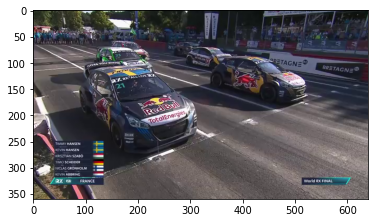

In [138]:
plt.imshow(frame)
plt.show()

In [18]:
HEIGHT = 224
WIDTH = 224

input_frame = cv2.resize(frame, (HEIGHT, WIDTH), cv2.INTER_AREA)
input_frame = input_frame[np.newaxis,:,:,:]

input_tensor = tf.convert_to_tensor(input_frame) #, dtype=tf.float32)
input_tensor.shape

TensorShape([1, 224, 224, 3])

In [17]:
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d0/1")

In [66]:

detector_output = detector(input_tensor)
num_detections = detector_output["num_detections"].numpy()
detection_boxes = detector_output["detection_boxes"].numpy()[0]
detection_scores = detector_output["detection_scores"].numpy()[0]
class_ids = detector_output["detection_classes"].numpy()[0]

In [120]:
threshold = 0.4
ind = np.where(detection_scores > threshold)
ind = np.squeeze(ind)
print(f"Total {len(ind)} objects found with confidence > {threshold}")

Total 5 objects found with confidence > 0.4


In [121]:
class_names = {3:'Vehicle'}

In [122]:
class_ids = class_ids[ind].astype('uint8')
ind = np.where(class_ids == 3)
ind = np.squeeze(ind)
print(f"Total {len(ind)} Cars found")

detection_boxes = detection_boxes[ind]
detection_scores = detection_scores[ind]

Total 5 Cars found


In [123]:
class_ids , detection_scores


(array([3, 3, 3, 3, 3], dtype=uint8),
 array([0.71161336, 0.69188917, 0.517278  , 0.4772195 , 0.44686887],
       dtype=float32))

In [139]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [140]:
class_names[3]

'Vehicle'

In [141]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  new_image = image.copy()
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format('Vehicle',
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(new_image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(new_image, np.array(image_pil))
  return new_image

In [142]:
detection_scores

array([0.71161336, 0.69188917, 0.517278  , 0.4772195 , 0.44686887],
      dtype=float32)

In [143]:
image_with_boxes = draw_boxes(
    frame, detection_boxes,
    class_ids, detection_scores)

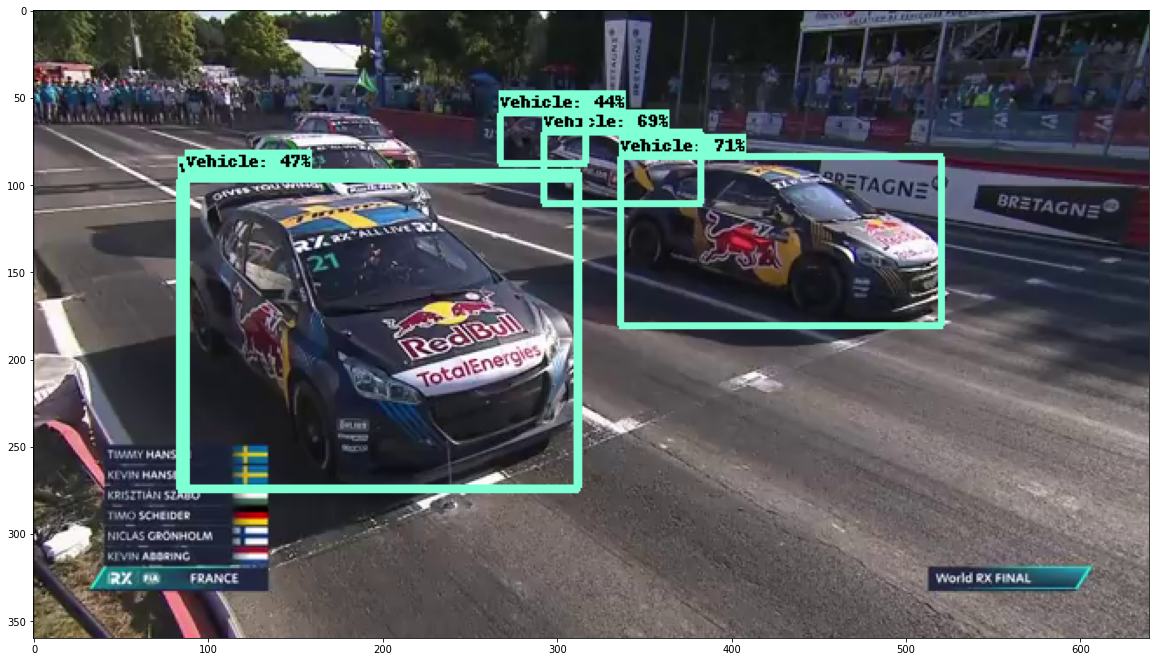

In [144]:
fig = plt.figure(figsize=(20, 15))
plt.imshow(image_with_boxes)
plt.show()

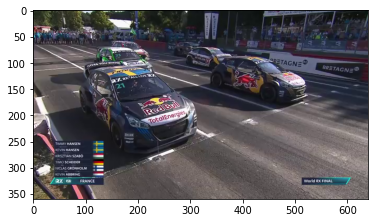

In [145]:
plt.imshow(frame)
plt.show()